In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random, device_put

KEY = random.PRNGKey(0)

In [2]:
# Global variables/parameters (will have to be passed to the functions anyways)

# Discrete/continuum boundary
DISCRETE_CONTINUUM_BOUNDARY = 10

# Define the discrete energy levels
DISCRETE_ENERGIES = jnp.array([0, 3, 5, 7, 8, 9, 9.5, 10])
DISCRETE_LEVEL_NUMBER = len(DISCRETE_ENERGIES)
# And the transition strengths between them
DCW = random.uniform(KEY, shape=(DISCRETE_LEVEL_NUMBER, DISCRETE_LEVEL_NUMBER))
DISCRETE_DECAY_WIDTHS = DCW + DCW.T
# Diagonal must be 0
DCW = jnp.where(jnp.eye(DISCRETE_LEVEL_NUMBER), 0, DISCRETE_LEVEL_NUMBER)

# Define the continuum energy levels via an event density function
# Backshifted Fermi Gas
def rho_f(energy, discrete_continuum_boundary):
    return 1/(1 + jnp.exp((energy - discrete_continuum_boundary)/1.1))

def rho_0(energy, disp_parameter):
    return disp_parameter

def level_density(energy, discrete_continuum_boundary, disp_parameter):
    return 100 * (1/rho_f(energy, discrete_continuum_boundary) + 1/rho_0(energy, disp_parameter))**(-1)

# Define the continuum transition strengths
# Just a sine wave lmao (transition strenght should be 0 for E_gamma = 0 and smooth at 0)
def transition_strength(gamma_energy):
    ts = jnp.sin(gamma_energy)**2 * 5 * jnp.exp(-gamma_energy/10)
    ts = jnp.where(gamma_energy < 0, 0, ts)
    
    return ts

# (differential) decay width
def differential_decay_width(energy, gamma_energy, discrete_continuum_boundary, disp_parameter):
    return level_density(energy, discrete_continuum_boundary, disp_parameter) * transition_strength(gamma_energy)


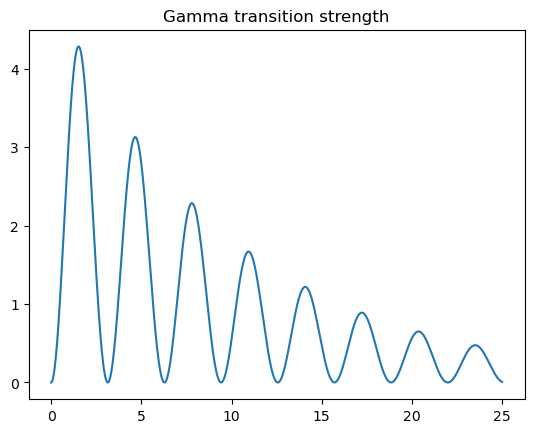

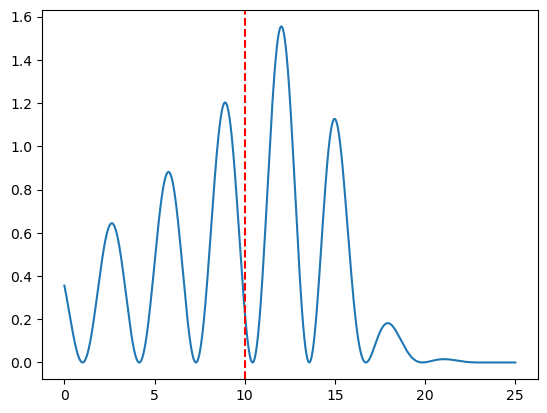

In [3]:
energies = np.linspace(0, 25, 1000)
# Starting energy
start_energy = 23

# plt.plot(energies, event_density(energies))
# # Vertical dashed line at the discrete/continuum boundary
# plt.axvline(discrete_continuum_boundary, linestyle='--', color='red')
#plt.yscale('log')

plt.figure()
plt.plot(energies, transition_strength(energies))
plt.title("Gamma transition strength")

gamma_energies = start_energy - energies
plt.figure()
plt.plot(energies, differential_decay_width(energies, gamma_energies, 
                                        discrete_continuum_boundary=DISCRETE_CONTINUUM_BOUNDARY, disp_parameter=0.01))
plt.axvline(DISCRETE_CONTINUUM_BOUNDARY, linestyle='--', color='red')

In [4]:
# We can precompute the total decay width for each energy, saving us a lot of time
def total_decay_widths_to_continuum(energies, discrete_continuum_boundary, disp_parameter):
    total_decay_widths_to_continuum = {}
    for energy in energies:
        supp_energies = np.linspace(0, energy, 1000)
        total_decay_width_to_continuum = np.sum(differential_decay_width(supp_energies, energy - supp_energies, 
                                                                          discrete_continuum_boundary, disp_parameter)) * np.diff(supp_energies)[0]
        total_decay_widths_to_continuum[energy] = total_decay_width_to_continuum

    return total_decay_widths_to_continuum
    

def total_decay_width_to_discrete(energies, discrete_energies):
    total_decay_width_to_discrete = {}
    for energy in energies:
        total_decay_width_to_discrete[energy] = np.sum(transition_strength(energy - discrete_energies))
    
    return total_decay_width_to_discrete

In [5]:
def continuum_step_probability_density(start_energy, end_energy, discrete_continuum_boundary, disp_parameter, discrete_energies):
    # Calculate the total decay width for the given starting energy state
    energies = jnp.linspace(discrete_continuum_boundary, start_energy, 1000)
    total_decay_width_to_continuum = jnp.sum(differential_decay_width(energies, start_energy - energies, 
                                                                        discrete_continuum_boundary, disp_parameter)) * jnp.diff(energies)[0]
    # Also need to consider the probabality that this step didn't just go to a discrete level
    total_decay_width_to_discrete = jnp.sum(transition_strength(start_energy - discrete_energies))

    # Calculate the differential decay width for the given energies
    ddw = differential_decay_width(end_energy, start_energy - end_energy, discrete_continuum_boundary, disp_parameter)
    probability_density = ddw / (total_decay_width_to_continuum + total_decay_width_to_discrete)

    return probability_density

def continuum_to_discrete_step_probability(start_energy, end_discrete_level, discrete_continuum_boundary,
                                            disp_parameter, discrete_energies):
    # Calculate the differential decay width for the given energies
    end_energy = discrete_energies[end_discrete_level]

    # Calculate the total decay width for the given starting energy state
    energies = jnp.linspace(discrete_continuum_boundary, start_energy, 1000)
    total_decay_width_to_continuum = jnp.sum(differential_decay_width(energies, start_energy - energies, 
                                                                      discrete_continuum_boundary, disp_parameter)) * jnp.diff(energies)[0]
    # Also need to consider the probabality that this step didn't just go to a discrete level
    total_decay_width_to_discrete = jnp.sum(transition_strength(start_energy - discrete_energies))

    # Calculate the probability density
    probability_density = transition_strength(start_energy - end_energy) / (total_decay_width_to_discrete + total_decay_width_to_continuum)

    return probability_density

def discrete_step_probability(start_level, end_level, discrete_decay_widths):
    probability = discrete_decay_widths[start_level, end_level] / np.sum(discrete_decay_widths[start_level, :start_level])
    return probability


# Jit and vectorize the functions
continuum_step_probability_density_jit = jit(continuum_step_probability_density)
continuum_to_discrete_step_probability_jit = jit(continuum_to_discrete_step_probability)

continuum_step_probability_density_vmap_start_energy = vmap(continuum_step_probability_density_jit, in_axes=(0, None, None, None, None), out_axes=0)
continuum_step_probability_density_vmap = vmap(continuum_step_probability_density_vmap_start_energy, in_axes=(None, 0, None, None, None), out_axes=1)

continuum_to_discrete_step_probability_vmap_energy = vmap(continuum_to_discrete_step_probability_jit, in_axes=(0, None, None, None, None), out_axes=0)
continuum_to_discrete_step_probability_vmap = vmap(continuum_to_discrete_step_probability_vmap_energy, in_axes=(None, 0, None, None, None), out_axes=1)


# pd = continuum_step_probability_density(23, 18, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES)

# %timeit continuum_step_probability_density(23, 18, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES)
# %timeit continuum_step_probability_density_jit(23, 18, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES) #.block_until_ready()

In [6]:
high_energy = 23
start_energies = jnp.array([23])
num_points = 2000
bin_width = (high_energy - DISCRETE_CONTINUUM_BOUNDARY) / num_points

discrete_levels = jnp.arange(DISCRETE_LEVEL_NUMBER).reshape(-1, 1)
intermediate_energies = jnp.linspace(DISCRETE_CONTINUUM_BOUNDARY, high_energy, num_points)

prob_density_0 = continuum_step_probability_density_vmap(start_energies, intermediate_energies, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES)
prob_density_1 = continuum_to_discrete_step_probability_vmap(intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES).squeeze()

print(prob_density_0.shape)
print(prob_density_1.shape)
# print(prob_density_1)

prob_density = jnp.einsum('ki,ij->kj', prob_density_0, prob_density_1)
prob = jnp.einsum('ij->i', prob_density) * bin_width
print(prob.shape)

print(prob)

(1, 2000)
(2000, 8)
(1,)
[0.31704134]


In [7]:
high_energy = 24
num_points = 4000
start_energies = jnp.linspace(DISCRETE_CONTINUUM_BOUNDARY, high_energy, num_points)
intermediate_energies = jnp.linspace(DISCRETE_CONTINUUM_BOUNDARY, high_energy, num_points)
bin_width = (high_energy - DISCRETE_CONTINUUM_BOUNDARY) / num_points

# Total probability of a decay from the high energy for a number of continuum steps
def continuum_total_probability(order, start_energies, intermediate_energies, discrete_levels, discrete_continuum_boundary, disp_parameter, discrete_energies):
    prob_density_continuum = continuum_step_probability_density_vmap(start_energies, intermediate_energies, discrete_continuum_boundary, disp_parameter, discrete_energies)
    prob_density_discrete = continuum_to_discrete_step_probability_vmap(intermediate_energies, discrete_levels, discrete_continuum_boundary, disp_parameter, discrete_energies).squeeze()

    prob_density_pre = jnp.eye(num_points)
    for i in range(order):
        prob_density_pre = jnp.einsum('ab,bc->ac', prob_density_pre, prob_density_continuum)
    prob_density_pre = prob_density_pre[-1, :].reshape(1,-1) # Only interested on the probability of decay from the high energy

    prob_density_to_discrete = jnp.einsum('ki,ij->kj', prob_density_pre, prob_density_discrete)
    prob = jnp.einsum('ij->i', prob_density_to_discrete) * bin_width**order
    return prob[0]

total_prob = 0
for i in range(11):
    prob = continuum_total_probability(i, start_energies, intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, 0.01, DISCRETE_ENERGIES)
    total_prob += prob
    print("Order {}:".format(i), prob)

print(total_prob)


Order 0: 0.5173652
Order 1: 0.30578932
Order 2: 0.13668078
Order 3: 0.033746097
Order 4: 0.0048766723
Order 5: 0.0006159038
Order 6: 4.394713e-05
Order 7: 1.8229243e-06
Order 8: 5.169164e-08
Order 9: 1.0902066e-09
Order 10: 1.7178184e-11
0.9991199


In [134]:
# Take the gradient of the continuum_total_probability function
df = grad(continuum_total_probability, argnums=(5,6))
print(df)

<function continuum_total_probability at 0x4710bb060>


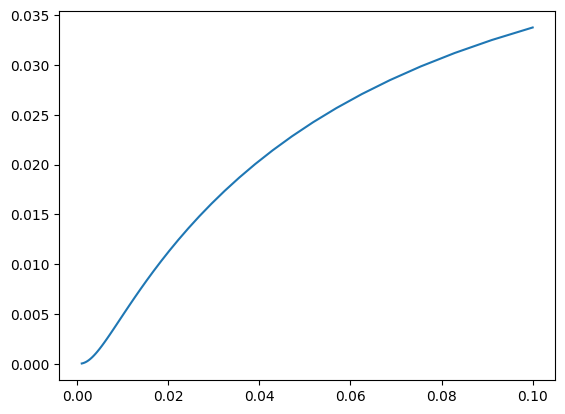

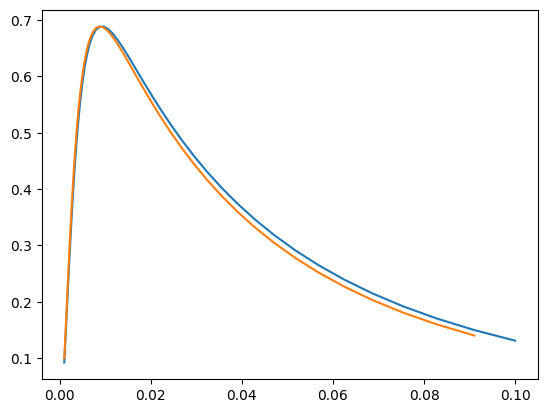

: 

In [154]:
# Derivative wrt the displacement parameter in the Fermi function
probs = []
grads = []

disp_params = np.logspace(-3, -1, 50)

order = 4
for x in disp_params:
    probs.append(continuum_total_probability(order, start_energies, intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, x, DISCRETE_ENERGIES))
    grads.append(df(order, start_energies, intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, x, DISCRETE_ENERGIES)[0])

plt.figure()
plt.plot(disp_params, probs)

plt.figure()
plt.plot(disp_params, grads)
plt.plot(disp_params[:-1], np.diff(probs)/np.diff(disp_params))

In [147]:
# Derivatives wrt the discrete energies
probs = []
grads = []

#DISCRETE_ENERGIES = jnp.array([0, 3, 5, 7, 8, 9, 9.5, 10])
discrete_energies = jnp.array([0, 3, 5, 7, 8, 9, 9.5, 10], dtype=jnp.float32)
print(type(discrete_energies))

for i in range(10):
    for j in range(10):
        discrete_energies = discrete_energies.at[1].set(3.0 + i/10)
        discrete_energies = discrete_energies.at[2].set(5.0 + j/10)

        probs.append(continuum_total_probability(order, start_energies, intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, 0.01, discrete_energies))
        grads.append(df(order, start_energies, intermediate_energies, discrete_levels, DISCRETE_CONTINUUM_BOUNDARY, 0.01, discrete_energies)[1])

# Plot 2D gradient of the probability
plt.figure()
plt.plot(probs)
plt.figure()
plt.imshow(np.array(grads).reshape(10,10))
plt.colorbar()



<class 'jaxlib.xla_extension.ArrayImpl'>


XlaRuntimeError: UNKNOWN: /var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_59457/3716604558.py:11:28: error: 'mps.scatter_nd' op invalid batch dimensions: 0, must be less than ranks of all input tensors
/var/folders/jn/g_gtx_qn7f9411g8ktr24lrh0000gn/T/ipykernel_59457/3716604558.py:11:28: note: see current operation: %0 = "mps.scatter_nd"(%arg0, %arg2, %arg1) <{batch_dims = 0 : ui32, mode = #mps.scatter_mode<set>}> : (tensor<8xf32>, tensor<f32>, tensor<1xsi32>) -> tensor<8xf32>
